# <font color='darkblue'>__01 · Relational Model with SQLite__</font>

**Wichtig:** Dieses Notebook erwartet eine Ordnerstruktur wie folgt **im gleichen Verzeichnis wie das Notebook**:
```
notebooks/
  01_sqlite_relpaths.ipynb
  data/
    relational/
      users.csv
      posts.csv
      follows.csv
      likes.csv
      comments.csv
```
Falls dein `data/`-Ordner eine Ebene höher liegt, passe den Pfad unten einfach auf `Path("../data/relational")` an.


---

In [1]:
# ## Setup (Relative Paths)
# - Arbeitet mit relativen Pfaden ausgehend vom Notebook-Standort
# - Legt die SQLite-DB als Datei im aktuellen Verzeichnis an
from pathlib import Path
import pandas as pd
import sqlite3
import warnings

# Optional: unterdrücke die 'bottleneck'-Warnung, falls veraltet installiert ist
warnings.filterwarnings("ignore", message="Pandas requires version '1.3.6' or newer of 'bottleneck'")

BASE = Path('.').resolve()
REL = BASE / 'data' / 'relational'         # <- Hier liegt dein data/relational Ordner
DB_PATH = BASE / 'sqlite_workshop.db'      # DB-Datei im Notebook-Ordner

print('Notebook base:', BASE)
print('Relational data path:', REL)
print('DB path:', DB_PATH)

# Sanity checks
required = ['users.csv','posts.csv','follows.csv','likes.csv','comments.csv']
missing = [f for f in required if not (REL / f).exists()]
if missing:
    raise FileNotFoundError(f"Fehlende Dateien im {REL}: {missing}\n"
                            "Prüfe, dass dein Ordner 'data/relational' relativ zum Notebook liegt.")

users = pd.read_csv(REL / "users.csv", parse_dates=["created_at"])
posts = pd.read_csv(REL / "posts.csv", parse_dates=["created_at"])
follows = pd.read_csv(REL / "follows.csv", parse_dates=["since"])
likes = pd.read_csv(REL / "likes.csv", parse_dates=["created_at"])
comments = pd.read_csv(REL / "comments.csv", parse_dates=["created_at"])

users.head(2), posts.head(2)


C:\Users\pell\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Notebook base: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT
Relational data path: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT\data\relational
DB path: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT\sqlite_workshop.db


(   user_id     username created_at
 0        1  user_qahftr 2024-11-06
 1        2  user_ckafna 2025-05-03,
    post_id  user_id created_at  \
 0        1        1 2025-08-23   
 1        2        1 2025-08-24   
 
                                                 text  
 0  Coffee tinyflux data social ai trend sqlite gr...  
 1  Follow python cloud trend social mongodb socia...  )

In [2]:
# Schreibe in SQLite und lege Indizes an
con = sqlite3.connect(DB_PATH)
users.to_sql("users", con, if_exists="replace", index=False)
posts.to_sql("posts", con, if_exists="replace", index=False)
follows.to_sql("follows", con, if_exists="replace", index=False)
likes.to_sql("likes", con, if_exists="replace", index=False)
comments.to_sql("comments", con, if_exists="replace", index=False)

cur = con.cursor()
cur.executescript('''
CREATE INDEX IF NOT EXISTS idx_posts_user_created ON posts(user_id, created_at);
CREATE INDEX IF NOT EXISTS idx_likes_post ON likes(post_id);
CREATE INDEX IF NOT EXISTS idx_comments_post ON comments(post_id);
CREATE INDEX IF NOT EXISTS idx_follows_src ON follows(src_user_id);
CREATE INDEX IF NOT EXISTS idx_follows_dst ON follows(dst_user_id);
CREATE INDEX IF NOT EXISTS idx_users_id ON users(user_id);
''')
con.commit()
con.close()

print('SQLite DB bereit:', DB_PATH)


SQLite DB bereit: C:\Users\pell\Documents\3__UNTERRICHT_STUDENTENBETREUUNG\MAS_BE\CAS Data Engineering\2025\06_Storage\_ChatGPT\sqlite_workshop.db


## Q1 · Aktivste Nutzer:innen (Engagement)

**Definition**
- `posts_count` = Anzahl Posts pro Nutzer
- `comments_made` = Anzahl verfasster Kommentare
- `likes_made` = Anzahl gegebener Likes
- `engagement_score` = `posts_count + comments_made + likes_made`

> Hinweis: In relationalen Systemen entstehen solche Metriken typischerweise über **Aggregationen + Joins**.


In [4]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)

sql = '''
select * from comments;
'''
df_q1 = pd.read_sql(sql, con)
con.close()
df_q1


,comment_id,post_id,user_id,created_at,text
0,1,1,104,2025-08-25 16:00:00,Like mongodb cloud trend coffee data ml sqlite...
1,2,3,65,2025-08-19 12:00:00,Ai ai data music social music sql post tinyflu...
2,3,6,126,2025-08-31 21:00:00,Stream stream stream post sqlite ml music ai t...
3,4,6,119,2025-08-31 11:00:00,Stream ml music data tinyflux coffee follow post.
4,5,8,71,2025-08-26 15:00:00,Graph ml music graph ai ml coffee trend sqlite.
...,...,...,...,...,...
507,508,860,106,2025-08-15 05:00:00,Neo4j sqlite follow post music music music nlp...
508,509,860,42,2025-08-13 18:00:00,Music music graph graph ai python coffee graph.
509,510,860,50,2025-08-14 22:00:00,Neo4j python ai data tinyflux neo4j nlp post s...
510,511,861,199,2025-09-11 17:00:00,Coffee social ml music social stream music post.


In [3]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)

sql = '''
WITH
p AS (
  SELECT user_id, COUNT(*) AS posts_count
  FROM posts
  GROUP BY user_id
),
c AS (
  SELECT user_id, COUNT(*) AS comments_made
  FROM comments
  GROUP BY user_id
),
l AS (
  SELECT user_id, COUNT(*) AS likes_made
  FROM likes
  GROUP BY user_id
)
SELECT
  u.user_id,
  u.username,
  COALESCE(p.posts_count,0) AS posts_count,
  COALESCE(c.comments_made,0) AS comments_made,
  COALESCE(l.likes_made,0) AS likes_made,
  (COALESCE(p.posts_count,0)+COALESCE(c.comments_made,0)+COALESCE(l.likes_made,0)) AS engagement_score
FROM users u
LEFT JOIN p ON p.user_id = u.user_id
LEFT JOIN c ON c.user_id = u.user_id
LEFT JOIN l ON l.user_id = u.user_id
ORDER BY engagement_score DESC, posts_count DESC
LIMIT 20;
'''
df_q1 = pd.read_sql(sql, con)
con.close()
df_q1


,user_id,username,posts_count,comments_made,likes_made,engagement_score
0,94,user_ethptp,10,4,12,26
1,107,user_nmcbli,10,5,11,26
2,35,user_eycepr,5,6,14,25
3,11,user_kbxosf,8,4,12,24
4,156,user_muncny,10,6,7,23
5,43,user_rwngxb,9,3,11,23
6,104,user_yuqryl,7,7,9,23
7,15,user_kpmgoy,12,2,8,22
8,198,user_aitdje,9,3,10,22
9,138,user_qxqilp,4,6,12,22


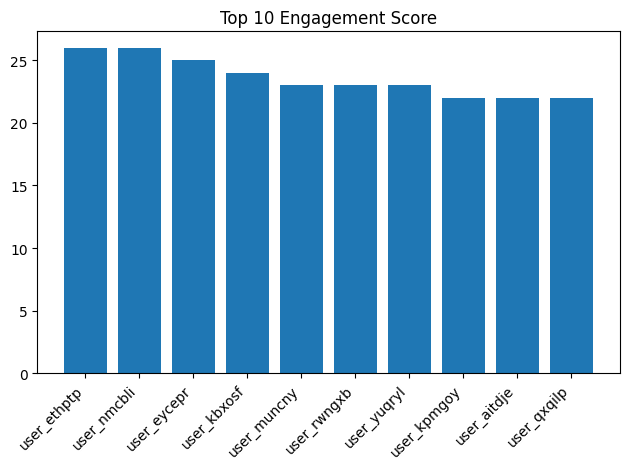

In [4]:
# Visualisierung Top-10 Engagement (matplotlib, ohne Styles/Farben)
import matplotlib.pyplot as plt

top10 = df_q1.head(10)
plt.figure()
plt.bar(top10['username'], top10['engagement_score'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Engagement Score')
plt.tight_layout()


## Q2 · Beliebteste Posts (Likes)
Welche Posts erhielten die meisten Likes? Zeige zusätzlich Autor:in und Erstellungsdatum.


In [5]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)
sql = '''
SELECT
  p.post_id,
  u.username AS author,
  DATE(p.created_at) AS day,
  COUNT(l.like_id) AS like_count,
  SUBSTR(p.text, 1, 80) || '…' AS preview
FROM posts p
JOIN users u ON u.user_id = p.user_id
LEFT JOIN likes l ON l.post_id = p.post_id
GROUP BY p.post_id, u.username, DATE(p.created_at), preview
ORDER BY like_count DESC, p.post_id ASC
LIMIT 20;
'''
df_q2 = pd.read_sql(sql, con)
con.close()
df_q2


,post_id,author,day,like_count,preview
0,136,user_ywemfk,2025-08-16,4,Sqlite ai trend sqlite post.…
1,138,user_ywemfk,2025-08-26,4,Cloud ai social coffee trend post social post ...
2,184,user_nroycw,2025-08-13,4,Data tinyflux social ai nlp sqlite.…
3,291,user_djdfki,2025-08-26,4,Tinyflux post cloud neo4j social ai tinyflux n...
4,292,user_djdfki,2025-09-05,4,Ml post coffee like post sql data follow pytho...
5,293,user_djdfki,2025-08-26,4,Trend follow mongodb nlp mongodb follow cloud ...
6,336,user_zjquqt,2025-08-31,4,Cloud post post follow music cloud graph ai ti...
7,381,user_iwshay,2025-08-23,4,Sql ai sqlite sql sqlite post post.…
8,384,user_gkogms,2025-08-15,4,Sql cloud graph ml coffee cloud nlp data.…
9,386,user_ucfrhp,2025-09-10,4,Graph follow neo4j follow sqlite sqlite follow...


## Q3 · Graph-Insights in SQL
**Follower-/Following-Degree** sind tabellarisch gut machbar. **Shortest Path** wird hingegen komplex und ist ein gutes Beispiel für die Grenzen relationaler Abfragen bei Graph-Traversals.


In [6]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)
sql_deg = '''
WITH
followers AS (
  SELECT dst_user_id AS user_id, COUNT(*) AS followers
  FROM follows
  GROUP BY dst_user_id
),
following AS (
  SELECT src_user_id AS user_id, COUNT(*) AS following
  FROM follows
  GROUP BY src_user_id
)
SELECT
  u.user_id, u.username,
  COALESCE(followers.followers,0) AS followers,
  COALESCE(following.following,0) AS following
FROM users u
LEFT JOIN followers ON followers.user_id = u.user_id
LEFT JOIN following ON following.user_id = u.user_id
ORDER BY followers DESC, following DESC
LIMIT 20;
'''
df_deg = pd.read_sql(sql_deg, con)
con.close()
df_deg


,user_id,username,followers,following
0,80,user_mgjpzs,27,23
1,90,user_gkogms,25,23
2,98,user_cbmprd,25,23
3,141,user_ticzdz,25,5
4,154,user_oucwdj,24,25
5,41,user_nroycw,22,22
6,71,user_kfkxps,22,22
7,108,user_afrwpa,22,22
8,91,user_ucfrhp,22,9
9,10,user_rfitbv,21,22


In [7]:
# Beispiel: Kürzeste Pfadlänge zwischen zwei Nutzern via Recursive CTE
# Tipp: In Neo4j ist das eine Einzeiler-Query; hier dient es als Demonstration der Komplexität.
import sqlite3, pandas as pd, random
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

# zwei zufällige Nutzer (verschiedene IDs)
user_ids = pd.read_sql('SELECT user_id FROM users ORDER BY RANDOM() LIMIT 2;', con)['user_id'].tolist()
src, dst = user_ids[0], user_ids[1]
print("Quelle:", src, "Ziel:", dst)

sql_sp = f'''
WITH RECURSIVE
  frontier(user_id, depth, path) AS (
    SELECT {src} AS user_id, 0 AS depth, CAST({src} AS TEXT)
    UNION ALL
    SELECT f.dst_user_id, frontier.depth + 1, path || '->' || f.dst_user_id
    FROM follows f
    JOIN frontier ON f.src_user_id = frontier.user_id
    WHERE depth < 5  -- Tiefenlimit als Schutz
      AND INSTR(path, '->' || f.dst_user_id) = 0  -- einfache Zyklusvermeidung
  )
SELECT * FROM frontier WHERE user_id = {dst} ORDER BY depth ASC LIMIT 1;
'''
res = pd.read_sql(sql_sp, con)
con.close()
res if not res.empty else pd.DataFrame([{"info":"Kein Pfad bis Tiefe 5 gefunden"}])


Quelle: 108 Ziel: 186


,user_id,depth,path
0,186,2,108->22->186


## Q4 · Trends über Zeit (Posts/Tag, 7d-Rolling)
Wir zeigen zwei Wege:
1. **SQL (Window Functions)** – wenn die SQLite-Version Window Functions unterstützt  
2. **Pandas** – robuster Fallback


In [8]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)
try:
    sql_trend = '''
    WITH daily AS (
      SELECT DATE(created_at) AS day, COUNT(*) AS posts
      FROM posts
      GROUP BY DATE(created_at)
    )
    SELECT
      day,
      posts,
      AVG(posts) OVER (ORDER BY day ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS rolling_7d
    FROM daily
    ORDER BY day;
    '''
    df_trend = pd.read_sql(sql_trend, con)
    used_sql_window = True
except Exception as e:
    # Fallback: reine Tageswerte, Rolling in Pandas
    daily = pd.read_sql('SELECT DATE(created_at) AS day, COUNT(*) AS posts FROM posts GROUP BY DATE(created_at) ORDER BY 1;', con)
    daily['day'] = pd.to_datetime(daily['day'])
    daily['rolling_7d'] = daily['posts'].rolling(7, min_periods=1).mean()
    df_trend = daily
    used_sql_window = False

con.close()
print("SQL Window Functions verwendet:", used_sql_window)
df_trend.head()


SQL Window Functions verwendet: True


,day,posts,rolling_7d
0,2025-08-12,22,22.000000
1,2025-08-13,24,23.000000
2,2025-08-14,31,25.666667
3,2025-08-15,39,29.000000
4,2025-08-16,31,29.400000


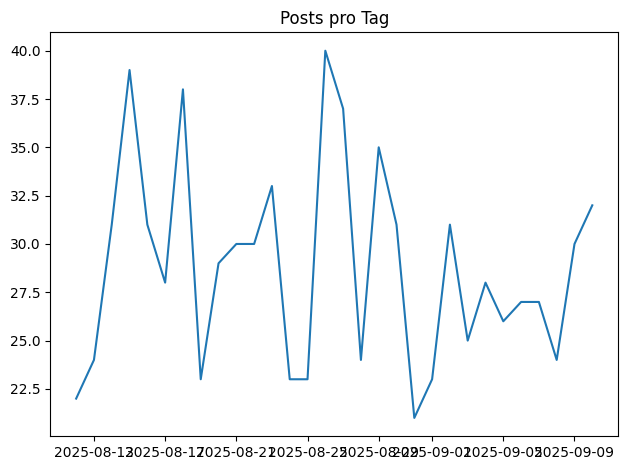

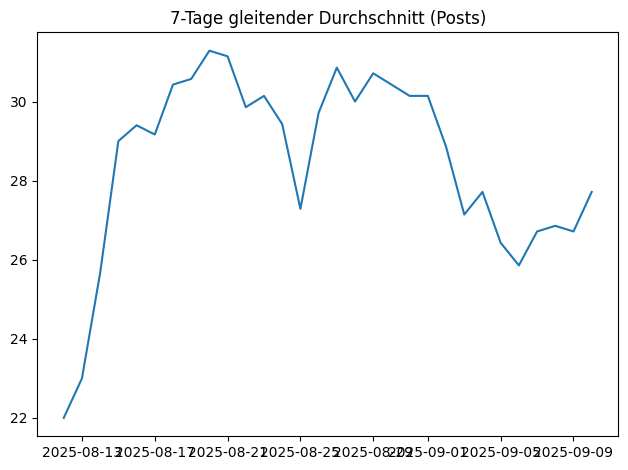

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['posts'])
plt.title('Posts pro Tag')
plt.tight_layout()

plt.figure()
plt.plot(pd.to_datetime(df_trend['day']), df_trend['rolling_7d'])
plt.title('7-Tage gleitender Durchschnitt (Posts)')
plt.tight_layout()


## Q5 · Feed-Abfrage (Posts der Gefolgten in den letzten X Tagen)
Parameter: `viewer_user_id`, `days_back`  


In [10]:
import sqlite3, pandas as pd
from datetime import datetime, timedelta

viewer_user_id = 1
days_back = 3

con = sqlite3.connect(DB_PATH)
params = {
    "viewer": viewer_user_id,
    "since": (pd.Timestamp('today').normalize() - pd.Timedelta(days=days_back)).date().isoformat()
}
sql_feed = '''
SELECT
  p.post_id, u.username AS author, p.created_at, SUBSTR(p.text, 1, 100) || '…' AS preview,
  (SELECT COUNT(*) FROM likes l WHERE l.post_id = p.post_id) AS like_count
FROM posts p
JOIN follows f ON f.dst_user_id = p.user_id
JOIN users u ON u.user_id = p.user_id
WHERE f.src_user_id = :viewer
  AND DATE(p.created_at) >= :since
ORDER BY p.created_at DESC
LIMIT 50;
'''
df_feed = pd.read_sql(sql_feed, con, params=params)
con.close()
df_feed.head(20)


,post_id,author,created_at,preview,like_count
0,399,user_ethptp,2025-09-10 00:00:00,Cloud neo4j graph ml python like.…,0
1,23,user_jigbld,2025-09-10 00:00:00,Mongodb sqlite nlp neo4j cloud social coffee s...,2
2,204,user_lhauqg,2025-09-09 00:00:00,Mongodb social mongodb mongodb graph follow tr...,3
3,396,user_ethptp,2025-09-08 00:00:00,Social like neo4j graph tinyflux python.…,0


## EXPLAIN QUERY PLAN (Beispiel)
Kurzer Blick auf den Plan der Feed-Query, um die Wirkung der Indizes zu illustrieren.


In [11]:
import sqlite3, pandas as pd
con = sqlite3.connect(DB_PATH)
plan = pd.read_sql("EXPLAIN QUERY PLAN " + '''
SELECT p.post_id
FROM posts p
JOIN follows f ON f.dst_user_id = p.user_id
WHERE f.src_user_id = 1
  AND DATE(p.created_at) >= DATE('now','-3 day');
''', con)
con.close()
plan


,id,parent,notused,detail
0,5,0,0,SEARCH f USING INDEX idx_follows_src (src_user...
1,10,0,0,SEARCH p USING INDEX idx_posts_user_created (u...


## Zusammenfassung (Relational · SQLite)

**Stärken**
- Strenges Schema, starke Konsistenz, mächtige Aggregationen und Joins.
- Gute Reproduzierbarkeit; klare Optimierung über Indizes.

**Schwächen (Use-Case-spezifisch)**
- Graph-Traversals (z. B. kürzeste Pfade, Communities) sind umständlich.
- Dokument-ähnliche Antworten (Post inkl. aller Kommentare) benötigen Joins oder Post-Processing.

**Merksatz**
> Relationale Modelle sind *exzellent* für tabellarische Konsistenz & Aggregationen –
> weniger bequem für tief verschachtelte Dokumente oder Graphpfade.
